In [41]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [42]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from numpy import pi

from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_qsphere

# Entanglement
___
## CNOT gates and entanglement
A good way to introduce entanglement is by studying the the controlled-NOT (CNOT) gate and the composition of two systems. We define the tensor product between operations $q_0$ and $q_1$ by: 

$$
q_1 \otimes q_0
$$

Where **$q_0$ is the control** and **$q_1$ is the target**. $q_0$ in computer science notation ussually corresponds to the Least Significant Bit (LSB). The CNOT with this representation is: 

$$
CNOT = \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
\end{pmatrix} 
$$

An entangled state of the two qubits can be made via an $H$ gate on the control qubit, followed by the CNOT gate. This creates a maximally entangled state known as a **Bell State**. 

___
## Experiment with the Bell State 

To explore the Bell state we can prepare an entangled state of two qubits and investigate the different states: 

* What is the state of the zeroth qubit in the standard basis?
* What is the state of the zeroth qubit in the superposition basis?
* What is the state of the first qubit in the standard basis?
* What is the state of the first qubit in the superposition basis?
* What is the state of both qubits in the standard basis?
* What is the state of both qubits in the superposition basis?

**NOTE:** Standard basis -> Computational basis

In [68]:
# custom error classes
class InvalidQuantumCircuit(ValueError):
    pass

class InvalidNumberQubits(InvalidQuantumCircuit):
    """Raised when the number of qubits is less then zero"""
    def __init__(self,number_qubits):
        self.number_qubits = number_qubits
        self.message = "Please use one or more qubits"
        super().__init__(self.message)
    
    def __str__(self):
        return f'{self.number_qubits} -> {self.message}'
    
class InvalidCountsObject(InvalidQuantumCircuit):
    """Raised when the counts dictionary returned does not have two keys"""
    def __init__(self,counts):
        self.counts
        self.message = "The counts dictinary can only have two entries"
        super().__init__(self.message)
    
    def __str__(self):
        return f'{self.counts} -> {self.message}'

In [131]:
from abc import ABCMeta, abstractmethod

class Quantum_circuit(metaclass = ABCMeta):
    
    number_circuits_created = 0
    
    def __init__(self, number_qubits):
        self.set_qubits(number_qubits)
        self.__base_circuit_setup()
        self.setup_two_qubit_entanglement(self)
        self.__class__.number_circuits_created += 1
        
    def __base_circuit_setup(self):
        """setups registers for quantum circuit"""
        # register setup
        self.qreg_q = QuantumRegister(self.get_qubits(), 'q')
        self.creg_c = ClassicalRegister(self.get_qubits(), 'c')
        circuit = QuantumCircuit(self.qreg_q, self.creg_c)
        self.circuit = circuit
        return
    
    
    def set_qubits(self,number_qubits):
        if number_qubits <= 0:
            raise InvalidNumberQubits(number_qubits)
        else: 
            self.__qubits = number_qubits
            
    def get_qubits(self):
        return self.__qubits
        
    def draw(self):
        self.circuit.draw()
        return
            
    def run_circuit_simulation(self):
        self.simulation_results = self.run_circuit(self.circuit)
        return self.simulation_results
        
    @classmethod
    def GHZ_circuit(self):
        """Build circuit for W state measurements"""
        self.set_qubits(3)
        self.__base_circuit_setup()
        circuit = self.circuit
        qreg_q, creg_c = self.qreg_q, self.creg_c

        # boilerplate
        circuit.reset(qreg_q[0])
        circuit.reset(qreg_q[1])
        circuit.reset(qreg_q[2])
        circuit.ry(1.9106332362490184, qreg_q[0])
        circuit.cu(pi/2, pi/2, pi/2, pi/2, qreg_q[0], qreg_q[1])
        circuit.cx(qreg_q[1], qreg_q[2])
        circuit.cx(qreg_q[0], qreg_q[1])
        circuit.x(qreg_q[0])

        # measurement
        circuit.measure(qreg_q[0], creg_c[0])
        circuit.measure(qreg_q[1], creg_c[1])
        circuit.measure(qreg_q[2], creg_c[2])
        return
        
    @abstractmethod
    def circuit_setup(self):
        pass
        
    @staticmethod
    def run_circuit(circuit):
        """Run the simulation on a circuit object"""
        backend = BasicAer.get_backend('qasm_simulator')
        job = execute(circuit, backend)
        return job
        
    @staticmethod
    def calculate_probabilities(counts):
        """calculate proabability of binary outcomes"""
        try: 
            x, y = counts
            probability_function = lambda x,y : x/(x+y), y/(x+y)
            return probability_function(x[1], y[1])
        
        except InvalidQuantumCircuit as err:
            self.handle_err(err)
    
    @staticmethod
    def setup_two_qubit_entanglement(Quantum_circuit):
        """setups two qubit entanglement"""
        circuit = Quantum_circuit.circuit
        qreg_q, creg_c = Quantum_circuit.qreg_q, Quantum_circuit.creg_c
        # bell state entanglement
        circuit.reset(qreg_q[0])
        circuit.h(qreg_q[0])
        circuit.reset(qreg_q[1])
        circuit.cx(qreg_q[0], qreg_q[1])  
        return
    
    @staticmethod
    def handle_err(err):
        raise err

In [132]:
class Zq0_circuit(Quantum_circuit):
    """Constructs the circuit for the z-measurement on qubit-0"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.circuit_setup()
        
    def circuit_setup(self):
        qreg_q, creg_c = self.qreg_q, self.creg_c
        self.circuit.measure(qreg_q[0], creg_c[0])
    

class Xq0_circuit(Quantum_circuit):
    """Constructs the circuit for the x-measurement on qubit-0"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.circuit_setup()
        
    def circuit_setup(self):
        qreg_q, creg_c = self.qreg_q, self.creg_c
        circuit = self.circuit
        circuit.h(qreg_q[0])
        circuit.measure(qreg_q[0], creg_c[0])
    
class Zq1_circuit(Quantum_circuit):
    """Constructs the circuit for the z-measurement on qubit-1"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.circuit_setup()
        
    def circuit_setup(self):
        qreg_q, creg_c = self.qreg_q, self.creg_c
        self.circuit.measure(qreg_q[1], creg_c[1])

class Xq1_circuit(Quantum_circuit):
    """Constructs the circuit for the x-measurement on qubit-1"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.circuit_setup()
        
    def circuit_setup(self):
        qreg_q, creg_c = self.qreg_q, self.creg_c
        circuit = self.circuit
        circuit.h(qreg_q[1])
        circuit.measure(qreg_q[1], creg_c[1])

class ZZ_circuit(Quantum_circuit):
    """Constructs the circuit for the zz-measurement on both qubits"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.circuit_setup()
        
    def circuit_setup(self):
        qreg_q, creg_c = self.qreg_q, self.creg_c
        self.circuit.measure(qreg_q[0], creg_c[0])
        self.circuit.measure(qreg_q[1], creg_c[1])
        

class XX_circuit(Quantum_circuit):
    """Constructs the circuit for the xx-measurement on both qubits"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.circuit_setup()
        
    def circuit_setup(self):
        qreg_q, creg_c = self.qreg_q, self.creg_c
        circuit = self.circuit
        circuit.h(qreg_q[0])
        circuit.h(qreg_q[1])
        circuit.measure(qreg_q[0], creg_c[0])
        circuit.measure(qreg_q[1], creg_c[1])

___
## Measurements on qubit 0
### Bell state + z-measurement on qubit 0

![image](../md_images/Bell12.png)

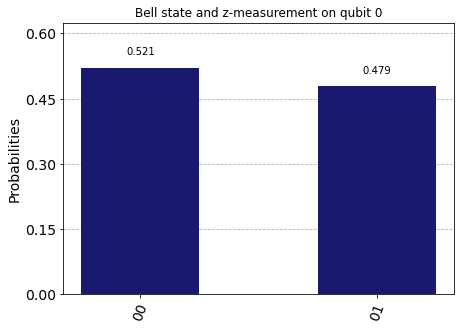

In [123]:
c = Zq0_circuit(2)
job = c.run_circuit_simulation()
plot_histogram(job.result().get_counts(), color='midnightblue', title="Bell state and z-measurement on qubit 0")

Half the time $q_0$ is in $|0>$ and the other half it is in the $|1>$ state. This seems to mimick the behaviour that we saw in the superposition of a single qubit using the **computational basis**. In the next experiment we measure $q_0$ in the **superposition basis**. 

### Bell state + x-measurement on qubit 0

![image](../md_images/Bell22.png)

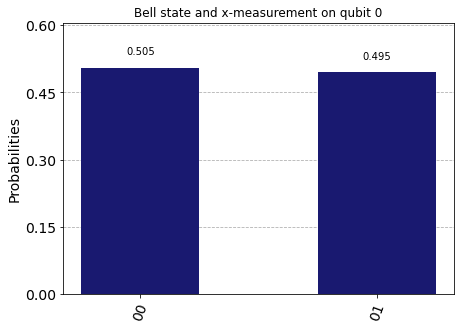

In [124]:
c = Xq0_circuit(2)
job = c.run_circuit_simulation()
plot_histogram(job.result().get_counts(), color='midnightblue', title="Bell state and x-measurement on qubit 0")

We see that even in the **superposition basis** the result is still random. This tells us **we know nothing about $q_0$**. 

___
## Measurments on qubit 1
### Bell state + z-measurement on qubit 1

![image](../md_images/Bell32.png)

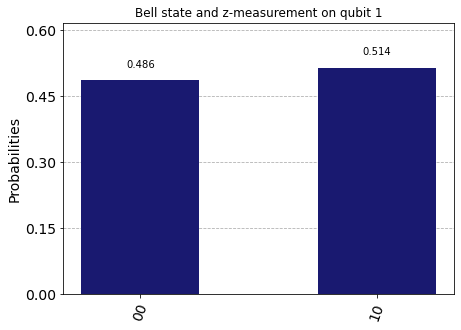

In [125]:
# simulation results
c = Zq1_circuit(2)
job = c.run_circuit_simulation()
plot_histogram(job.result().get_counts(), color='midnightblue', title="Bell state and z-measurement on qubit 1")

This experiment shows that in the **computational basis** we know nothing about $q_1$. 

### Bell state + x-measurement on qubit 1

![image](../md_images/Bell42.png)

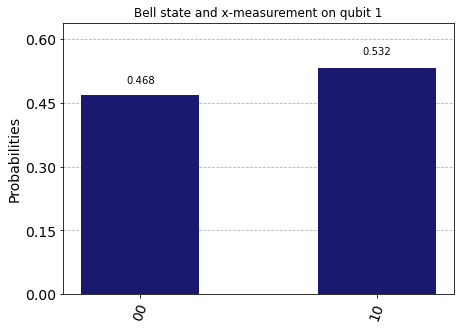

In [126]:
# simulation results 
c = Xq1_circuit(2)
job = c.run_circuit_simulation()
plot_histogram(job.result().get_counts(), color='midnightblue', title="Bell state and x-measurement on qubit 1")

In the **superposition basis**, just like the computational basis, we know nothing about $q_1$.

___
## Measurements on both qubits
### Bell state + zz-measurement on qubits

![image](../md_images/Bell52.png)

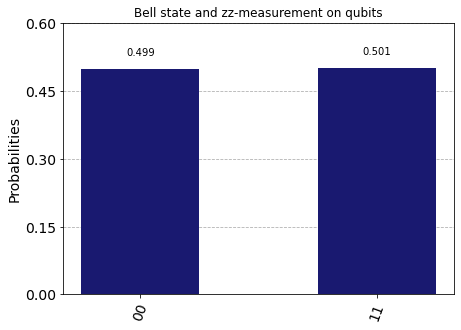

In [127]:
# simulation results
c = ZZ_circuit(2)
job = c.run_circuit_simulation()
plot_histogram(job.result().get_counts(), color='midnightblue', title="Bell state and zz-measurement on qubits")

Here we see that with high probability, if $q_0$ is in state 0, $q_1$ will be in 0 as well; the same goes if $q_0$ is in state 1. They are perfectly correlated.
Note that two of the basis states are missing $|10>$ and $|01>$.

### Bell state + xx-measurement on qubits

![image](../md_images/Bell62.png)

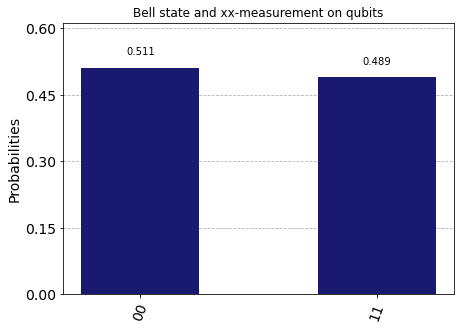

In [128]:
# simulation results 
c = XX_circuit(2)
job = c.run_circuit_simulation()
plot_histogram(job.result().get_counts(), color='midnightblue', title="Bell state and xx-measurement on qubits")

Here we see that even in another basis the system also has **perfect correlations (accounting for experimental noise)**. Therefore, if $q_0$ is measured in state $|0>$, we know that $q_1$ is in this state as well; likewise, if $q_0$ is measured in state $|+>$, we know $q_1$ is also in this state.

___
## GHZ states

Perhaps even stranger than Bell states are their three-qubit generalization, the *GHZ states.* An example of a GHZ state is: 

$$
|\psi> = \frac{1}{\sqrt{2}}(|000> + |111>) 
$$

A GHZ state can be constructed using the circuit below: 

![image](../md_images/ghz-circ4.png)

In [133]:
def build_GHZ_circuit():
    """Builds a GHZ circuit"""
    qreg_q = QuantumRegister(3, 'q')
    creg_c = ClassicalRegister(3, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    
    # initialize GHZ states
    circuit.reset(qreg_q[0])
    circuit.reset(qreg_q[1])
    circuit.h(qreg_q[0])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.reset(qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[2])
    
    # measure qubits
    circuit.measure(qreg_q[0], creg_c[0])
    circuit.measure(qreg_q[1], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[2])
    
    return circuit

In [134]:
# build and run GHZ circuit
c = build_GHZ_circuit()

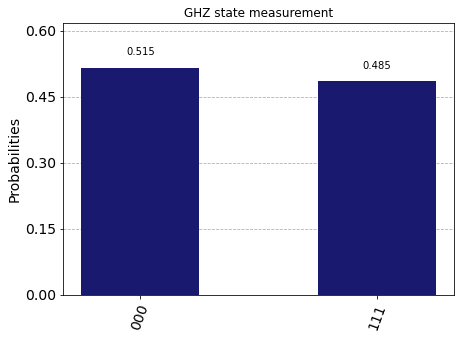

In [135]:
job = Quantum_circuit.run_circuit(c)
plot_histogram(job.result().get_counts(), color='midnightblue', title="GHZ state measurement")

___
## W states vs. GHZ states

W states are another way to entangle 3 qubits. Compared to GHZ states they are more robustly entangled when a qubit is lost. Comparing the two different entangled states: 

$$
\begin{align*}
|GHZ_3> &= \frac{1}{\sqrt{2}}(|000> + |111>) \\
|W_3> &= \frac{1}{\sqrt{3}}(|010> + |100>) 
\end{align*}
$$

### GHZ states

If we start with the $|GHZ_3>$ state and **lose a qubit by measuring it** the states will be no longer entangled. The resulting output $|\psi_{m}^{GHZ}>$ depends on the outcome **$m$**. The outcome **$m$** is uniformily random. The resulting state is either: 

$$
\begin{align*}
|\psi_{0}^{GHZ}> &= |00> \\
& OR \\
|\psi_{1}^{GHZ}> &= |11> \\
\end{align*}
$$

Which means neither the states are no longer entangled after one qubit is measured.

### W states

If we start with a $|W_3>$ state and measure one qubit there is a chance that the resulting state can be maximally entangled. Again the resulting state, $|\psi_{m}^{W}>$, depends on the measurement outcome **$m$**. 

Outcome **$m$** is 0 two-thirds of the time and 1 the rest of the time. The resulting state is either: 

$$
\begin{align*}
|\psi_{0}^{W}> &= \frac{1}{\sqrt{2}}(|01> + |10>) \\
&OR\\ 
|\psi_{1}^{W}> &= |00> \\
\end{align*}
$$

Although $|\psi_{1}^{W}>$ is **not entangled**, $|\psi_{0}^{W}>$ is a **maximally entangled** state of two qubits. This is also known as the **residual entanglement**. This resulting state can actually be used to teleport a qubit two-thirds of the time which will be discussed in the section on teleportation.

## Constructing a W-state

Below is an example of a circuit that can entangle three qubits in an entangled W state:

![image](../md_images/circuit-w2.png)

In [136]:
def build_W_circuit():
    """Build circuit for W state measurements"""
    qreg_q = QuantumRegister(3, 'q')
    creg_c = ClassicalRegister(3, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)

    # boilerplate
    circuit.reset(qreg_q[0])
    circuit.reset(qreg_q[1])
    circuit.reset(qreg_q[2])
    circuit.ry(1.9106332362490184, qreg_q[0])
    circuit.cu(pi/2, pi/2, pi/2, pi/2, qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.x(qreg_q[0])
    
    # measurement
    circuit.measure(qreg_q[0], creg_c[0])
    circuit.measure(qreg_q[1], creg_c[1])
    circuit.measure(qreg_q[2], creg_c[2])
    return circuit

In [137]:
# build and run GHZ circuit
c = build_W_circuit()

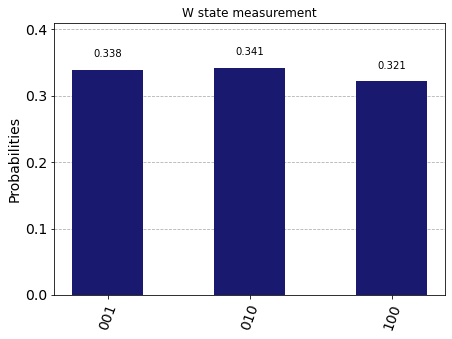

In [138]:
job = Quantum_circuit.run_circuit(c)
plot_histogram(job.result().get_counts(), color='midnightblue', title="W state measurement")

___
## Teleportation of qubits

Consider the circuit schematic below: 

![image](../md_images/teleport2.png)

The top most outcome **$m$** indicates whether or not the state has been successfully teleported. Also $|\psi>$ is the input state.

If **$m = 0$**, which happens two-thirds of the time then the output state of the circuit is $|\psi'> = X^{m_z+1}Z^{m_x}|\psi>$. This means we can look at **$m_z$** and **$m_x$** to **correct the output state to recover the original input state $|\psi>$**. 

On the otherhand if **$m = 1$**, which happens one-third of the time, then the output state is $|\psi'> = |0>$ and **we dont recover the original input state**. 

If we use a *GHZ state* this same **behaviour will not happen**. 

Here **Z** refers to the *Pauli-Z gate* and **X** refers to the *Not gate or Pauli-X gate*. 


### References

* Not gate : https://quantum-computing.ibm.com/admin/docs/admin/operations_glossary#not-gate
* Pauli-Z gate : https://quantum-computing.ibm.com/admin/docs/admin/operations_glossary#z-gate

#### Implementing this idea

![image](../md_images/teleporter_implementation.png)

In [139]:
def build_teleportation_circuit():
    """A function to build a 4-qubit teleportation"""
    # setting up registers
    qreg_q = QuantumRegister(4, 'q')
    creg_c = ClassicalRegister(4, 'c')
    circuit = QuantumCircuit(qreg_q, creg_c)
    
    # reset quantum registers
    circuit.reset(qreg_q[0])
    circuit.reset(qreg_q[1])
    circuit.reset(qreg_q[2])
    circuit.reset(qreg_q[3])
    
    # W-state setup
    circuit.ry(1.9106332362490184, qreg_q[0])
    circuit.h(qreg_q[3])
    circuit.cu(pi/2, pi/2, pi/2, pi/2, qreg_q[0], qreg_q[1])
    circuit.cx(qreg_q[1], qreg_q[2])
    circuit.cx(qreg_q[0], qreg_q[1])
    circuit.x(qreg_q[0])
    circuit.measure(qreg_q[0], creg_c[0])
    
    # teleportation setup
    circuit.cx(qreg_q[3], qreg_q[2])
    circuit.h(qreg_q[2])
    circuit.measure(qreg_q[2], creg_c[2])
    circuit.measure(qreg_q[3], creg_c[3])
    circuit.measure(qreg_q[1], creg_c[1])
    
    return circuit